# Runge Kutta módszerek (Explicit)
Készítette: Sykora Henrik - BME-GPK Műszaki Mechanikai Tanszék (sykora@mm.bme.hu)

Forrás: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

### Kezdetiérték feladat (KDE):
$\dot{y}(t) = f(y,t)$  

### Runge Kutta módszerek:  
Közelítsük a megoldást diszkrét időpontokban ($t_n = nh$):  
$y_n \approx y(t_n)$  

$\begin{align}
y_{n+1} = y_{n} + h \sum_{i=1}^s b_i k_i,
\end{align}$  
ahol  
$\begin{align}
k_1 &= \left(t_n,y_n\right), \\
k_2 &= \left(t_n+c_2 h,y_n+\left(a_{21}k_1\right) h\right), \\
k_3 &= \left(t_n+c_3 h,y_n+\left(a_{31}k_1+a_{32}k_2\right)h\right), \\
&\;\vdots \\
k_s &= \left(t_n+c_s h,y_n+\left(a_{s1}k_1+\ldots+a_{s,s-1}k_{s-1}\right)h\right). 
\end{align}$  

Az $a_i$, $b_i$ és $c_i$ paramétereket az úgynevezett *Butcher tábla* (*Butcher tableau*) tartalmazza:

$\begin{equation}
\renewcommand\arraystretch{1.2}
\begin{array}
{c|cccc}
0\\
c_2 & a_{2,1}\\
c_3 & a_{3,1} & a_{3,2} \\
\vdots & \vdots& & \ddots \\
c_s & a_{s,1} & a_{s,2} & \dots & a_{s,1}\\
\hline
& b_1 & b_2 & \dots & b_{s-1} & b_s
\end{array}
\end{equation}$

#### Egyszerű esetek:
Euler módszer:  
$\begin{equation}
\renewcommand\arraystretch{1.2}
\begin{array}
{c|cccc}
0\\
\hline
& 1
\end{array}
\end{equation}$  
$\begin{align}
y_{n+1} &= y_{n} + h  \cdot 1 \cdot k_1,\\
k_1 &= f(t_n, y_n).
\end{align}$

Negyedrendű Runge-Kutta módszer:  
$\begin{equation}
\renewcommand\arraystretch{1.2}
\begin{array}
{c|cccc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{2} &0 &\frac{1}{2} \\
1& 0& 0& 1\\
\hline
& \frac{1}{6} &\frac{1}{3} &\frac{1}{3} &\frac{1}{6} 
\end{array}
\end{equation}$  
$\begin{align}
y_{n+1} &= y_{n} + \frac{h}{6} \left(k_1+2k_2 + 2k_3 + k_4\right),\\
k_1 &= \left(t_n,y_n \right), \\
k_2 &= \left(t_n+\frac{1}{2} h, y_n+\frac{1}{2}k_1 h\right), \\
k_3 &= \left(t_n+\frac{1}{2} h, y_n+\frac{1}{2}k_2 h\right), \\
k_4 &= \left(t_n+ h, y_n+k_3 h\right). 
\end{align}$  

#### Megjegyzés: Adaptív Runge-Kutta módszerek
$\begin{equation}
\renewcommand\arraystretch{1.2}
\begin{array}
{c|cccc}
0\\
c_2 & a_{2,1}\\
c_3 & a_{3,1} & a_{3,2} \\
\vdots & \vdots& & \ddots \\
c_s & a_{s,1} & a_{s,2} & \dots & a_{s,1}\\
\hline
& b_1 & b_2 & \dots & b_{s-1} & b_s\\
& b_1^\ast & b_2^\ast & \dots & b_{s-1}^\ast & b_s^\ast
\end{array}
\end{equation}$  
Hibafüggvény ami alapján eldöntjük, hogy kell-e felezni/duplázni $h$ értékét:  
$e_{n+1} = y_n+1-y^\ast_n+1 = h \sum_{i=s}^s\left(b_i-b_i^\ast\right)k_i$

# Implementáció

In [1]:
# Számításokhoz és az eredmények megjelenítéséhez szükséges csomagok behívása
import numpy as np
import matplotlib.pyplot as mpl
# Segédfüggvény
def getzero(ll):
  return np.zeros(len(ll))

# Runge Kutta lépés osztály
class RKstep:
  def __init__(self,a,b,c,h):
    self.a = a
    self.b = b
    self.c = c
    self.h = h
    self.nk = len(c)

  def dy(self,f,t,y): # f(t_n,y_n) -> k
      ks=[getzero(y) for i in range(self.nk)]
      for (i,ci) in enumerate(self.c):
        ks[i]= f(t+ci*self.h,y + self.h*sum(self.a[i][j]*ks[j] for j in range(i)))
      return self.h*sum(k*self.b[i] for (i,k) in enumerate(ks))

# RK4 módszer
def RK4(h):
  a=[[],[1/2],[0,1/2],[0,0,1/2]]
  b=[1/6,1/3,1/3,1/6]
  c=[0,1/2,1/2,1]
  return RKstep(a,b,c,h)

# Euler módszer
def Euler(h):
  a=[[]]
  b=[1.]
  c=[0.]
  return RKstep(a,b,c,h)


# Közönséges differenciálegyenlet kezdetiérték problémájának megadása/megoldásfüggvénye osztályként
class ODEProblem:
  def __init__(self,f,y0,tspan):
    self.f = f
    self.y0 = y0 if type(y0)==np.ndarray else np.array(y0)
    self.tspan = tspan
    
  def solve(self,method):
    t0,T = self.tspan
    ts = np.arange(t0,T+100*np.finfo(float).eps,method.h)
    ys=[self.y0 for (i,t) in enumerate(ts)]
    for i in range(len(ys)-1):
      ys[i+1] = ys[i] + method.dy(self.f,ts[i],ys[i])
    return (ts,ys)

# Alkalmazás

Pl.:  
$\dot{y}(t) = y(t), \quad y(0) = y_0, \quad t \in \left[0,T\right]$

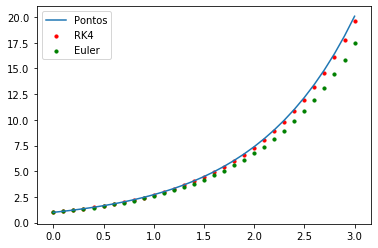

In [2]:
# Függvény és ODEProblem megadása
foo = lambda t,y: y#*np.sin(4*t)
y0=1.
T=3.
prob=ODEProblem(foo,[y0],(0.,T));

# Lépésköz + numerikus megoldás
h=0.1
# Runge Kutta megoldás
ts,ys=prob.solve(RK4(h))
#Euler módszer megoldás
tsE,ysE=prob.solve(Euler(h))

# Ábrázolás
mpl.plot(ts,np.exp(ts))
mpl.scatter(ts,[y[0] for y in ys],color='r',s=10)
mpl.scatter(tsE,[y[0] for y in ysE],color='g',s=10)
mpl.legend(['Pontos','RK4','Euler'])
mpl.show()